# Load Data

O Free Spoken Digit Dataset é uma coleção de gravações de áudio de declarações de dígitos (“zero” a “nove”) de diferentes pessoas.
O objetivo desta competição é identificar corretamente o dígito que está sendo pronunciado em cada gravação. 

In [1]:
from src.audioProcessor import AudioProcessor

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd


In [2]:
audio = AudioProcessor()
X = []
y = []
for audio_file in audio.audio_files:
   # X.append(audio_file.sample)
    y.append(int(audio_file.label))

files = 'data/recordings/'
ds_files = listdir(files)

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))

    X.append(data.astype(np.float32))

len(X), len(y)

INFO:src.audioProcessor:Found 3000 audio files in data/recordings


(3000, 3000)

In [3]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300]))





O problema está bem equilibrado: para cada uma das classes temos 300 amostras no conjunto de dados.
Todas as gravações são amostradas na taxa de 8 kHZ

Os sinais de áudio têm comprimentos diferentes.
Alguns deles têm intervalos iniciais e de silêncio.


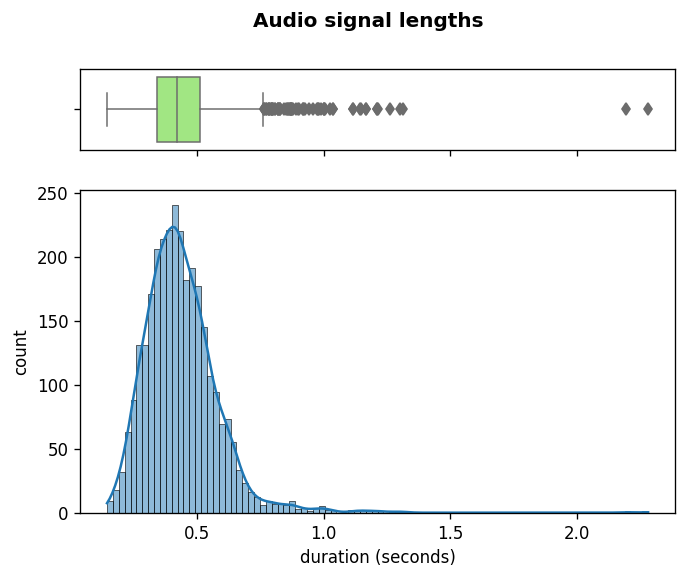

In [4]:
lengths = audio.show_length_distribution(X)

Casos extermos:

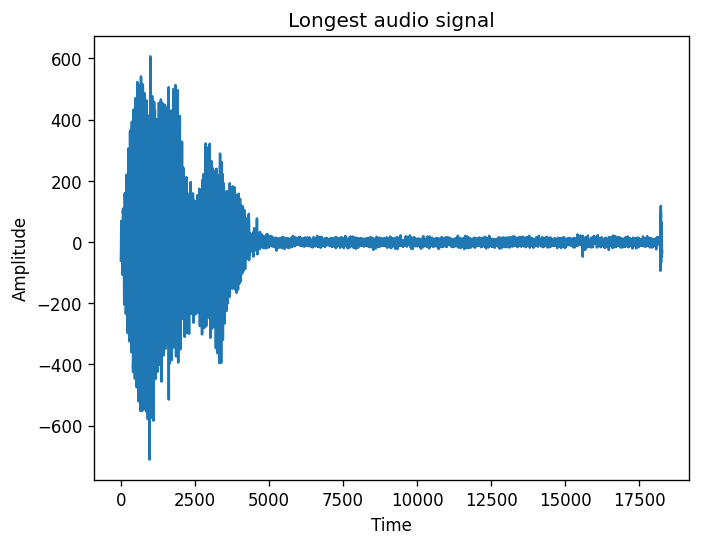

In [5]:
longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[longest_audio])
plt.title("Longest audio signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=audio.sample_rate))

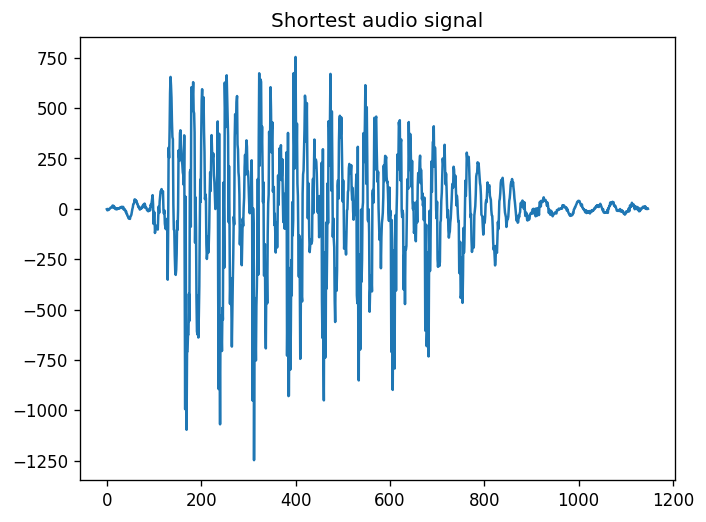

In [6]:
shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal")
plt.show()

display(ipd.Audio(X[shortest_audio], rate= audio.sample_rate))

## Remoção de recursos do domínio do tempo:
Vamos remover o silêncio inicial e final dos sinais para ver se obtemos uma distribuição diferente de comprimento. 

In [7]:
max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing before:', max_size)

# trim silence
X = [audio.remove_silence(x) for x in X ]


max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing after:', max_size)

INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence


Max sizing before: 18262


INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioProcessor:Removing silence
INFO:src.audioPr

Max sizing after: 6457


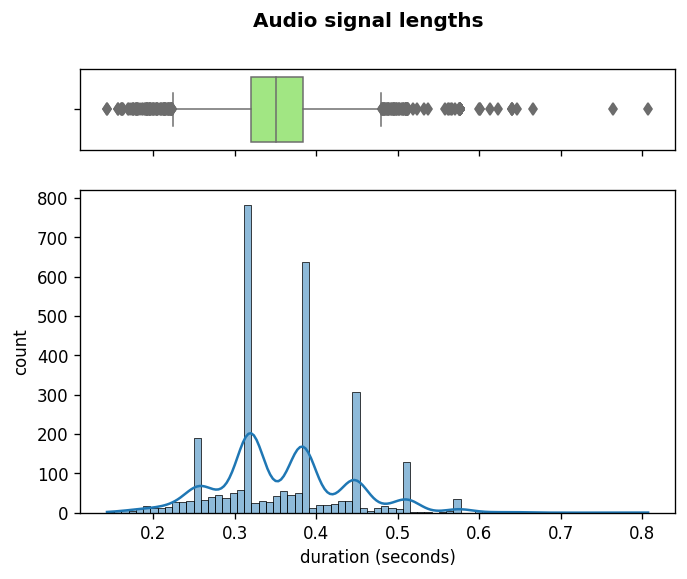

In [8]:
lengths = audio.show_length_distribution(X)

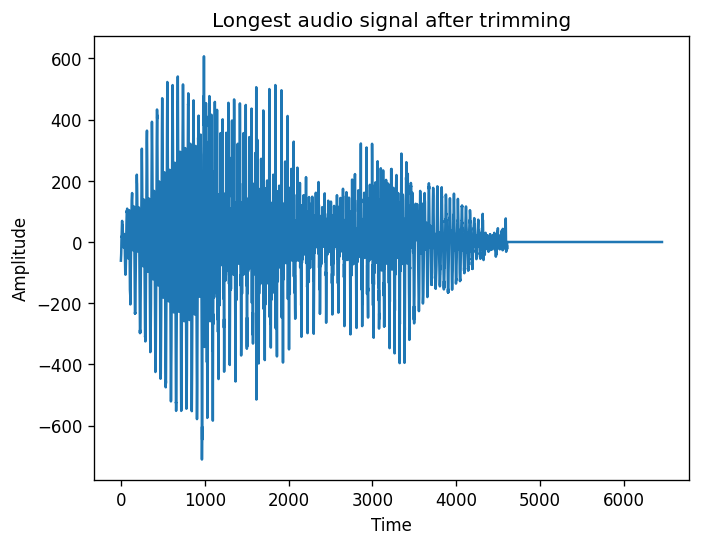

In [9]:
# add padding to max size
#! ATENÇÃO NÃO É O MESMO PADDING DO AUDIOPROCESSOR
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ] 

plt.plot(X[longest_audio])
plt.title("Longest audio signal after trimming")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=audio.sample_rate))

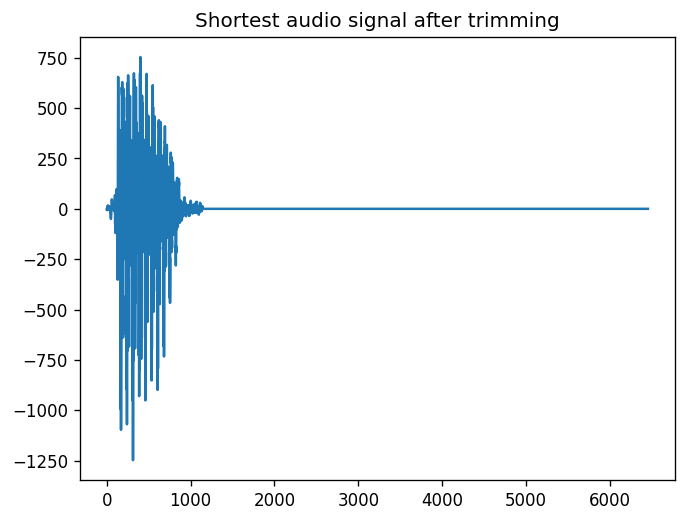

In [10]:
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal after trimming")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=audio.sample_rate))

# Spectorgrams

In [11]:
import librosa
import tensorflow as tf
import tensorflow_io as tfio

def freq_mask(spec):
    return tfio.audio.freq_mask(spec, param=2).numpy()

def time_mask(spec):
    return tfio.audio.time_mask(spec, param=2).numpy()


def mel_spectrogram(waveform):
    spec = librosa.feature.melspectrogram(y=waveform, sr=8000)
    return librosa.power_to_db(spec, ref=np.max)


def mfcc_spectrogram(waveform):
    return librosa.feature.mfcc(y=waveform, sr=8000)


def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)



def stft_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram



2023-06-17 14:56:55.012026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-17 14:56:55.430338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-17 14:56:55.432411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 14:56:58.067861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(128, 13)
(20, 13)


[Text(0.5, 1.0, 'MFCC Spectrogram with Freq. and Time Mask')]

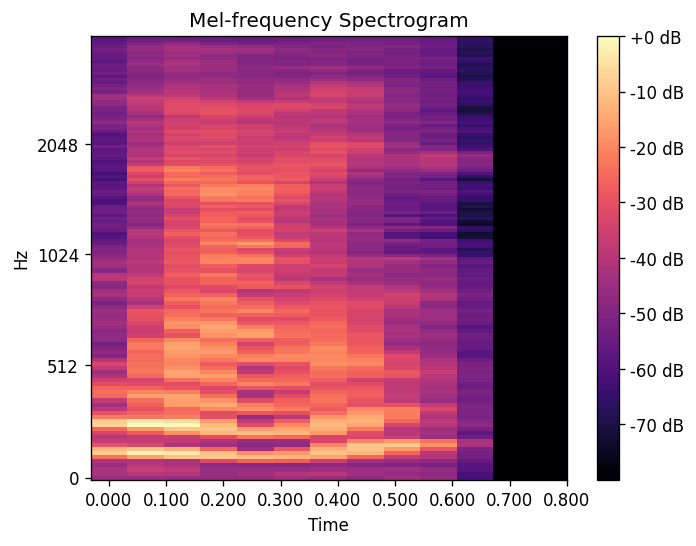

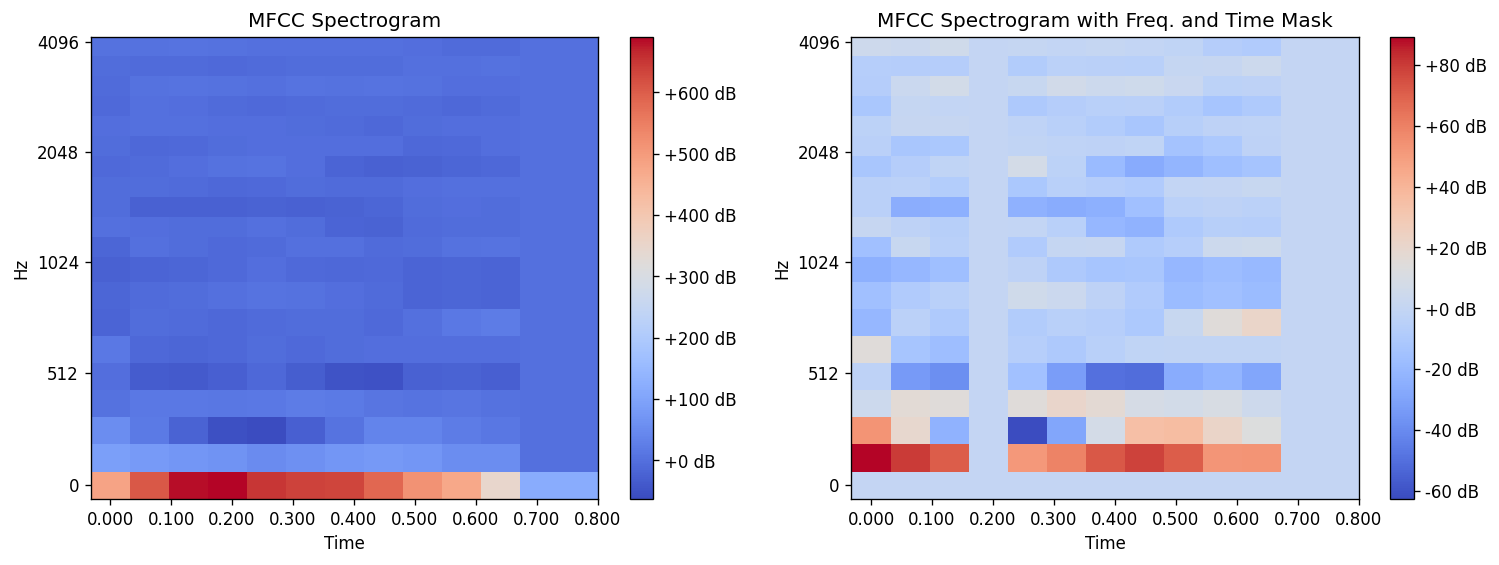

In [12]:
wave = X[longest_audio]

S = mel_spectrogram(wave)
print(S.shape)

fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram')



S = mfcc_spectrogram(wave)
print(S.shape)


fig, ax = plt.subplots(1,2)

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax[0])
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='MFCC Spectrogram')


S2 = freq_mask(time_mask(S))

#fig, ax = plt.subplots()

img = librosa.display.specshow(S2, x_axis='time',
                         y_axis='mel', sr=8000, ax=ax[1])

fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
fig.set_size_inches(15, 5)
ax[1].set(title='MFCC Spectrogram with Freq. and Time Mask')



(49, 129)


/tmp/ipykernel_196122/1214233773.py:24: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


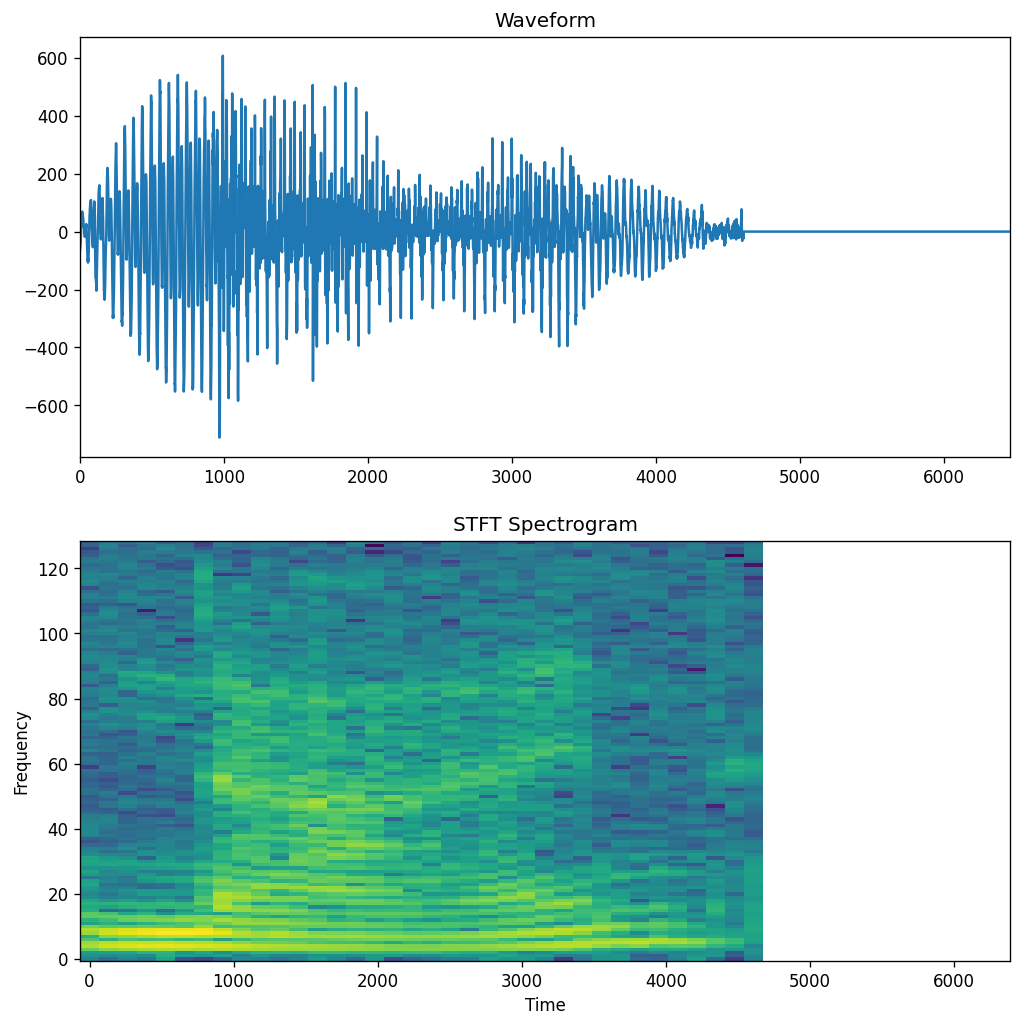

In [13]:
waveform = X[longest_audio]

spectrogram = stft_spectrogram(waveform).numpy()

#spectrogram.resize(32, 32)
print(spectrogram.shape)

timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])

fig.set_size_inches(10, 10)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('STFT Spectrogram')

plot_spectrogram(spectrogram, axes[1])